# E: Ejemplo real de calibración. Segunda fase: *darks*

Ahora trabajaremos con los *darks*: son las imágenes que tomamos con el mismo tiempo de exposición y la misma temperatura que los *lights* de los cuales hablaremos mas adelante.

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import glob
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
import os
from imstats import imstats

In [2]:
directorioCalibracion = 'salidas/salidaCalibracion/'
superBias = fits.open(directorioCalibracion + "superBias.fit")[0].data

## Apertura de los darks

Lo primero que haremos será al igual que con los *bias* localizar el directorio donde estos se encuentran.

In [3]:
# ls imagenes\calibracionImagenes\darks\*.fit

Vamos a crear una lista llamada ```dark_list``` que contendrá las rutas de los archivos que se encuentren dentro del directorio indicado.

In [4]:
darks_list = sorted(glob.glob('imagenes/calibracionImagenes/darks/*.fit'))
darks_list

['imagenes/calibracionImagenes/darks/Telescope3-001Dark_300_bin1.fit',
 'imagenes/calibracionImagenes/darks/Telescope3-002Dark_300_bin1.fit',
 'imagenes/calibracionImagenes/darks/Telescope3-003Dark_300_bin1.fit',
 'imagenes/calibracionImagenes/darks/Telescope3-004Dark_300_bin1.fit',
 'imagenes/calibracionImagenes/darks/Telescope3-005Dark_300_bin1.fit',
 'imagenes/calibracionImagenes/darks/Telescope3-006Dark_300_bin1.fit',
 'imagenes/calibracionImagenes/darks/Telescope3-007Dark_300_bin1.fit',
 'imagenes/calibracionImagenes/darks/Telescope3-008Dark_300_bin1.fit',
 'imagenes/calibracionImagenes/darks/Telescope3-009Dark_300_bin1.fit',
 'imagenes/calibracionImagenes/darks/Telescope3-010Dark_300_bin1.fit']

Procedemos a abrir los ficheros FITS como hicimos con los *bias* pero ahora usamos nuestra lista de *darks*.

In [5]:
darks_data = []
darks_header = []
for dark in darks_list:
    hdul_darks = fits.open(dark)
    darks_data.append(hdul_darks[0].data)
    darks_header.append(hdul_darks[0].header)
    hdul_darks.close()

hdul_darks.info()

Filename: imagenes/calibracionImagenes/darks/Telescope3-010Dark_300_bin1.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (4096, 4096)   uint16   


Comprobamos ahora que efectivamente son darks mediante los metadatos de la imagen.

In [6]:
hdul_darks[0].header['IMAGETYP']

'Dark Frame'

## Inspección de los darks

Vamos ha realizar una inspeccion de los *darks* con la funcion ```imstats``` para ver que los valores son razonables. Si detectamos cambios en los valores de la desviación estandar o en la media deberemos quitar estos archivos para que no afecte a las estadisticas de la imagen final.

In [7]:
median_darks = []
mean_darks = []
std_darks = []
for darks in range(len(darks_list)):
    median_darks.append(np.nanmedian(darks_data[darks]))
    mean_darks.append(np.nanmean(darks_data[darks]))
    std_darks.append(np.nanstd(darks_data[darks]))
    print(imstats(darks_data[darks]))

{'npix': 16777216, 'min': 958, 'max': 65535, 'mean': 1001.8412544131279, 'median': 1001.0, 'std': 57.27573095063457}
{'npix': 16777216, 'min': 958, 'max': 65535, 'mean': 1000.3297525644302, 'median': 1000.0, 'std': 57.20689177647265}
{'npix': 16777216, 'min': 961, 'max': 65535, 'mean': 1000.1423454284668, 'median': 999.0, 'std': 57.153036469556135}
{'npix': 16777216, 'min': 957, 'max': 65535, 'mean': 1000.0079499483109, 'median': 999.0, 'std': 57.70695002173296}
{'npix': 16777216, 'min': 962, 'max': 65535, 'mean': 1004.350045800209, 'median': 1004.0, 'std': 59.9808655791227}
{'npix': 16777216, 'min': 962, 'max': 65535, 'mean': 1002.8907271623611, 'median': 1002.0, 'std': 60.14471467665842}
{'npix': 16777216, 'min': 961, 'max': 65535, 'mean': 1001.7718186378479, 'median': 1001.0, 'std': 57.91686820756749}
{'npix': 16777216, 'min': 954, 'max': 65535, 'mean': 1001.2582774162292, 'median': 1001.0, 'std': 57.94924773320543}
{'npix': 16777216, 'min': 960, 'max': 65535, 'mean': 1001.004565358

### Graficamos la media y mediana

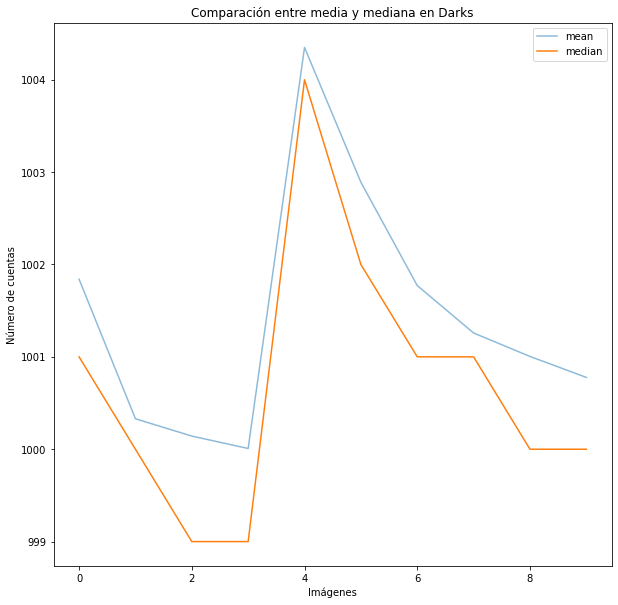

In [8]:
plt.figure("Darks", figsize=[10, 10])
plt.plot(np.arange(0,len(darks_list)),mean_darks, alpha=0.5, label='mean')
plt.plot(np.arange(0,len(darks_list)), median_darks, label='median')

plt.title('Comparación entre media y mediana en Darks')
plt.xlabel('Imágenes')
plt.ylabel('Número de cuentas')
plt.legend()
#plt.imshow(stacked, vmin=1000, vmax=2000, origin='lower')
#plt.colorbar(label='Counts')
plt.show()

### Graficamos la desviación estándar

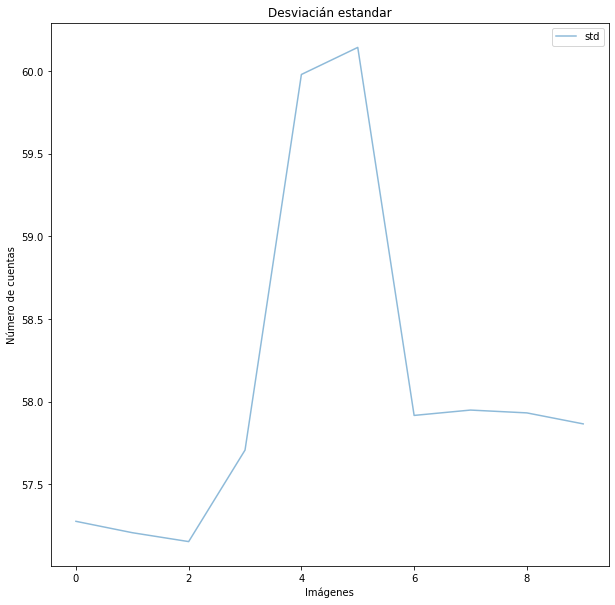

In [9]:
plt.figure("Darks", figsize=[10, 10])
plt.plot(np.arange(0,len(darks_list)),std_darks, alpha=0.5, label='std')

plt.title('Desviacián estandar')
plt.xlabel('Imágenes')
plt.ylabel('Número de cuentas')
plt.legend()
#plt.imshow(stacked, vmin=1000, vmax=2000, origin='lower')
#plt.colorbar(label='Counts')
plt.show()

## Creación del *superdark*

El *superdark* lo obtendremos igual que el *superbias*, haciendo un *stacking* de todos los *darks* que hemos seleccionado. En este caso no hemos eliminado ninguno.

Aqui tenemos dos opciones:

+ Realizar el *superdark* directamente (posteriormente tendremos que quitarle los *bias*).
+ Quitar a cada *dark* el *superbias* y posteriormente hacer el *stacking*. 

Vamos a proceder con el segundo método:

In [10]:
darks_current = []
for dark in range(len(darks_list)):
    darks_current.append(darks_data[dark] - superBias) # esto sería darkcurrent

La corriente oscura no puede ser negativa y por lo tanto los *dark frames* teóricamente deberían tener valores mas altos que el *superBias* pero en este caso tenemos algun valor negativo. Para que la estadistica no varíe mucho al realizar la mediana de los datos vamos a sustituir estos valores negativos por ceros.

In [11]:
for i in range(len(darks_list)):
    darks_current[i][darks_current[i] < 0] = 0

In [12]:
superDark = np.nanmedian(darks_data, axis=0)
darkCurrent = np.median(darks_current, axis=0)

In [13]:
darks_header[0]['history'] = f"esta imagen es un stacking de {len(darks_list)} imagenes" 

### Comprobamos el superdark

In [14]:
imstats(superDark)

{'npix': 16777216,
 'min': 974.5,
 'max': 65535.0,
 'mean': 1001.3304072022438,
 'median': 1000.5,
 'std': 57.52948028942413}

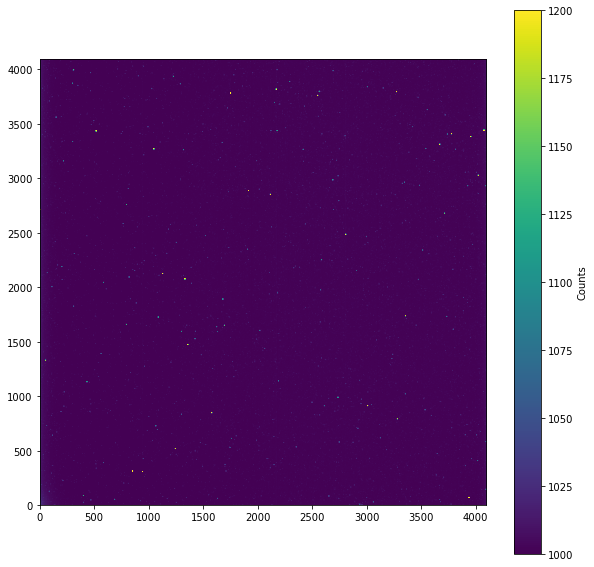

In [15]:
plt.figure("SuperDark", figsize=[10, 10])
plt.imshow(superDark, vmin=1000, vmax=1200, origin='lower')
plt.colorbar(label='Counts')
plt.show()

## Guardado del *superdark*

Guardaremos el *superdark* y la corriente oscura.

In [16]:
super_dark = fits.PrimaryHDU(data=superDark.astype(np.float32), header=darks_header[0])
super_dark.writeto(directorioCalibracion + "superDark.fit", overwrite=True)

In [17]:
hdu_Dark_current = fits.PrimaryHDU(data=darkCurrent.astype(np.float32))
hdu_Dark_current.writeto(directorioCalibracion + "darkCurrent.fit", overwrite=True)